### load packages

In [3]:
# for automatic reloading of modules (quick debugging)
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.append('..') # add parent directory to path

import numpy as np 
import pandas as pd
from utils import processing as pr
import matplotlib.pyplot as plt
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# ! pip install pyarrow fastparquet tqdm seaborn

### load data for range of time of choice
Here, we load data only for three months from 01-2023 to 03-2023. The function that I use loads the data for each month and year, performs some minimal processing (drop rows with dates outside the desired range), and bins the raw pickup ride data to an hourly count time series. At the end, we concatenate the dataframes corresponding to each month and year.

In [5]:
# preprocess months and years to an (N,2)-array
months = np.arange(1,3+1,1)
years = np.arange(2023,2023+1,1)
month_year = np.meshgrid(years, months)
month_year = np.array(month_year).T.reshape(-1,2)

In [4]:
# generate data
ts = pr.generate_processed_data(month_year, vehicle_type='yellow', by_value=['PULocationID', 'DOLocationID'], additional_features=True)
ts.head()

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:52<00:00, 17.51s/it]


,pickup_datetime,DOLocationID,PULocationID,counts,total_amount,tip_amount,fare_amount,trip_distance
0,2023-01-01 00:00:00-05:00,1,1,0,0.0,0.0,0.0,0.0
1,2023-01-01 00:00:00-05:00,6,1,0,0.0,0.0,0.0,0.0
2,2023-01-01 00:00:00-05:00,21,1,0,0.0,0.0,0.0,0.0
3,2023-01-01 00:00:00-05:00,52,1,0,0.0,0.0,0.0,0.0
4,2023-01-01 00:00:00-05:00,97,1,0,0.0,0.0,0.0,0.0


In [5]:
ts.pickup_datetime.min(), ts.pickup_datetime.max()

(Timestamp('2023-01-01 00:00:00-0500', tz='America/New_York'),
 Timestamp('2023-03-31 23:00:00-0400', tz='America/New_York'))

In [6]:
# basic checks, notice our code accounts for Daylight Savings Time
print('Min Date: ', ts.pickup_datetime.min())
print('Max Date: ', ts.pickup_datetime.max())
print('Taxi Zones: ' + str(ts.PULocationID.unique().min()) + ' to ' + str(ts.PULocationID.unique().max()) )
print('Memory Usage (MB): ', ts.memory_usage().sum() / 1024**2)

Min Date:  2023-01-01 00:00:00-05:00
Max Date:  2023-03-31 23:00:00-04:00
Taxi Zones: 1 to 265
Memory Usage (MB):  1562.8775367736816


In [7]:
ts.dtypes

pickup_datetime    datetime64[us, America/New_York]
DOLocationID                                  int32
PULocationID                                  int32
counts                                        int32
total_amount                                float32
tip_amount                                  float32
fare_amount                                 float32
trip_distance                               float32
dtype: object

### obtain time series for a single time zone (East Village)

In [8]:
ts_79 = ts[ts['PULocationID'] == 79]
gb = ts_79.groupby(['pickup_datetime', 'PULocationID'])

In [11]:
ts_79

,pickup_datetime,DOLocationID,PULocationID,counts,total_amount,tip_amount,fare_amount,trip_distance
5237,2023-01-01 00:00:00-05:00,1,79,0,0.000000,0.000,0.000000,0.000000
5238,2023-01-01 00:00:00-05:00,4,79,4,13.035000,1.185,6.850000,0.775000
5239,2023-01-01 00:00:00-05:00,7,79,2,41.099998,6.850,29.250000,5.910000
5240,2023-01-01 00:00:00-05:00,8,79,0,0.000000,0.000,0.000000,0.000000
5241,2023-01-01 00:00:00-05:00,9,79,0,0.000000,0.000,0.000000,0.000000
...,...,...,...,...,...,...,...,...
45505954,2023-03-31 23:00:00-04:00,261,79,3,30.296667,5.030,20.266668,3.813334
45505955,2023-03-31 23:00:00-04:00,262,79,6,30.843332,3.710,22.133333,4.033333
45505956,2023-03-31 23:00:00-04:00,263,79,10,31.429998,4.530,21.900000,4.247000
45505957,2023-03-31 23:00:00-04:00,264,79,1,15.450000,2.550,7.900000,0.700000


In [9]:
# from groupby, sum the counts and perform weighted average of total_amount, etc. using counts as weights
ts_79_p = pd.DataFrame(gb['counts'].sum())
ts_79_p['total_amount'] = gb.apply(lambda x: np.average(x['total_amount'], weights=x['counts']))
ts_79_p['trip_distance'] = gb.apply(lambda x: np.average(x['trip_distance'], weights=x['counts']))
ts_79_p['fare_amount'] = gb.apply(lambda x: np.average(x['fare_amount'], weights=x['counts']))
ts_79_p['tip_amount'] = gb.apply(lambda x: np.average(x['tip_amount'], weights=x['counts']))
ts_79_p = ts_79_p.reset_index()

/tmp/ipykernel_8433/2607528458.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ts_79_p['total_amount'] = gb.apply(lambda x: np.average(x['total_amount'], weights=x['counts']))
/tmp/ipykernel_8433/2607528458.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ts_79_p['trip_distance'] = gb.apply(lambda x: np.average(x['trip_distance'], weights=x['counts']))
/tmp/ipykernel_8433/2607528458.py:5: Deprecation

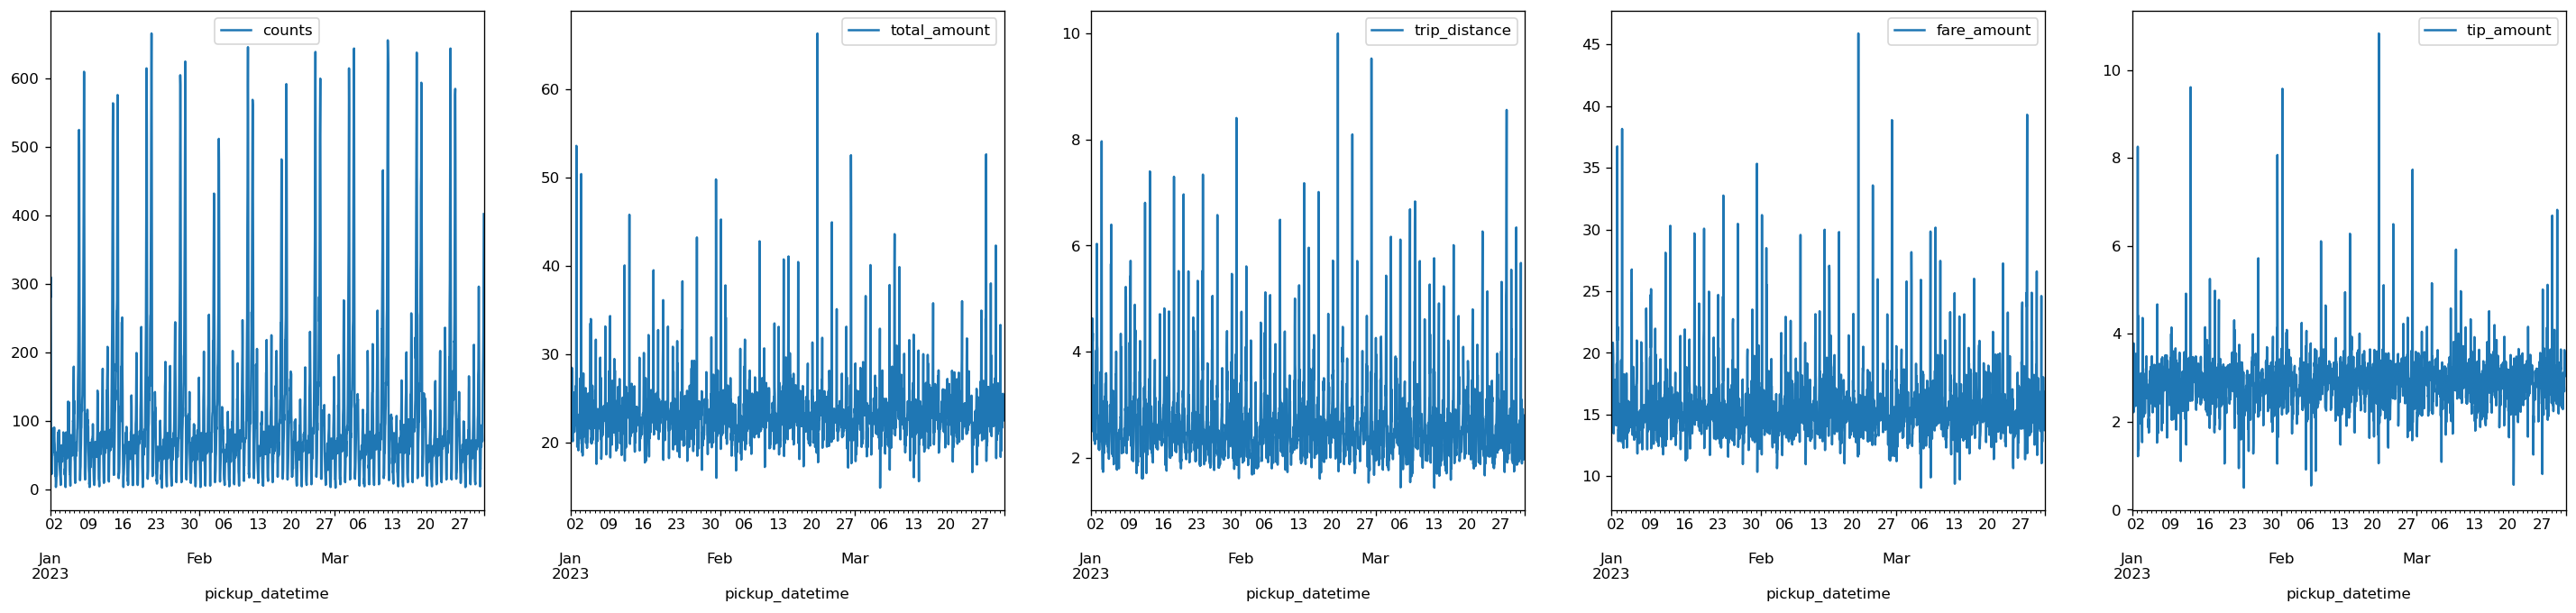

In [10]:
fig, axes = plt.subplots(figsize = (6*5, 6), dpi = 120, nrows = 1, ncols = 5)
for i, col in enumerate(['counts', 'total_amount', 'trip_distance', 'fare_amount', 'tip_amount']):
    ts_79_p.plot(x = 'pickup_datetime', y = col, ax = axes[i])

In [12]:
# save time series as pd dataframe
os.system('mkdir -p ../data')
ts.to_pickle('../data/yellow_2023-01_2023-03.pkl')

### perform test with less taxi zones in our dataset

### Filter Manhattan Only and Remove Islands as in 01_e_adjacency_graph.ipynb

In [6]:
zdf = pd.read_csv('../assets/taxi_zone_lookup.csv')
zdf = zdf[(zdf['Borough'] == 'Manhattan') & (~zdf['LocationID'].isin([103, 104, 105, 153, 194, 202]))]
taxi_zones = list(zdf['LocationID'].values)

In [7]:
# generate data
ts = pr.generate_processed_data(month_year, vehicle_type='yellow', by_value=['PULocationID', 'DOLocationID'], additional_features=True, taxi_zones=taxi_zones)
ts.head()

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:20<00:00,  6.73s/it]


,pickup_datetime,DOLocationID,PULocationID,counts,total_amount,tip_amount,fare_amount,trip_distance
0,2023-01-01 00:00:00-05:00,4,4,0,0.0,0.0,0.0,0.0
1,2023-01-01 00:00:00-05:00,12,4,0,0.0,0.0,0.0,0.0
2,2023-01-01 00:00:00-05:00,13,4,0,0.0,0.0,0.0,0.0
3,2023-01-01 00:00:00-05:00,24,4,0,0.0,0.0,0.0,0.0
4,2023-01-01 00:00:00-05:00,41,4,0,0.0,0.0,0.0,0.0


### obtain time series for a single time zone (East Village)

In [8]:
ts_79 = ts[ts['PULocationID'] == 79]
gb = ts_79.groupby(['pickup_datetime', 'PULocationID'])

In [9]:
# show summed counts
ts_79_p = pd.DataFrame(gb['counts'].sum())

In [15]:
# weighted-average function accounting for zero-weights
def weighted_average(x, weights):
    if (weights == np.zeros_like(x)).all():
        return 0.
    return np.average(x, weights=weights)

# from groupby, sum the counts and perform weighted average of total_amount, etc. using counts as weights
ts_79_p = pd.DataFrame(gb['counts'].sum())
ts_79_p['total_amount'] = gb.apply(lambda x: weighted_average(x['total_amount'], weights=x['counts']))
ts_79_p['trip_distance'] = gb.apply(lambda x: np.average(x['trip_distance'], weights=x['counts']))
ts_79_p['fare_amount'] = gb.apply(lambda x: np.average(x['fare_amount'], weights=x['counts']))
ts_79_p['tip_amount'] = gb.apply(lambda x: np.average(x['tip_amount'], weights=x['counts']))
ts_79_p = ts_79_p.reset_index()

/tmp/ipykernel_556/3046749799.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ts_79_p['total_amount'] = gb.apply(lambda x: weighted_average(x['total_amount'], np.zeros_like(x['counts'])))
/tmp/ipykernel_556/3046749799.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ts_79_p['trip_distance'] = gb.apply(lambda x: np.average(x['trip_distance'], weights=x['counts']))
/tmp/ipykernel_556/3046749799.py:10: 

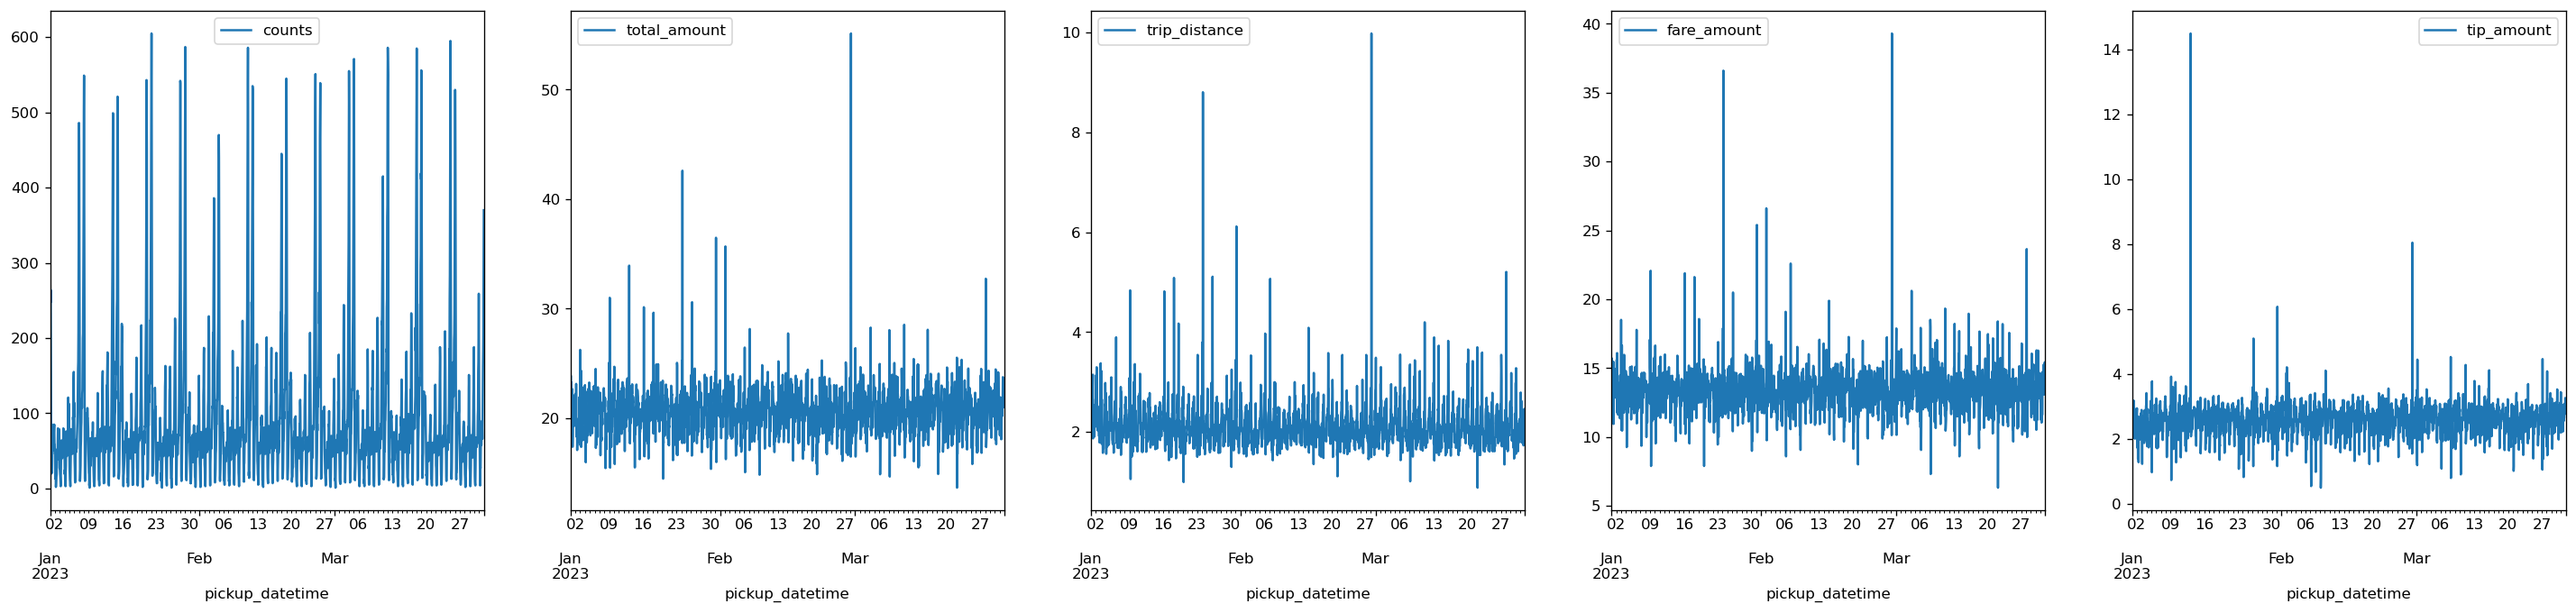

In [16]:
fig, axes = plt.subplots(figsize = (6*5, 6), dpi = 120, nrows = 1, ncols = 5)
for i, col in enumerate(['counts', 'total_amount', 'trip_distance', 'fare_amount', 'tip_amount']):
    ts_79_p.plot(x = 'pickup_datetime', y = col, ax = axes[i])

### Why are the Plots Different from Above?
By taking less taxi zones, the average over possible routes is now taken over a lesser amount of routes. By having less routes, there appears to be less variance due to the lesser amount of routes.